In [1]:
%matplotlib inline

In [2]:
! pip freeze

alabaster==0.7.10
anaconda-client==1.6.5
anaconda-navigator==1.6.9
anaconda-project==0.8.0
appnope==0.1.0
appscript==1.0.1
asn1crypto==0.22.0
astroid==1.5.3
astropy==2.0.2
Babel==2.5.0
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.6.0
bitarray==0.8.1
bkcharts==0.2
blaze==0.11.3
bleach==2.0.0
bokeh==0.12.10
boto==2.48.0
Bottleneck==1.2.1
certifi==2017.11.5
cffi==1.10.0
chardet==3.0.4
click==6.7
cloudpickle==0.4.0
clyent==1.2.2
colorama==0.3.9
conda==4.4.7
conda-build==3.0.27
conda-verify==2.0.0
contextlib2==0.5.5
cryptography==2.0.3
cycler==0.10.0
Cython==0.26.1
cytoolz==0.8.2
dask==0.15.3
datashape==0.5.4
decorator==4.1.2
distributed==1.19.1
docutils==0.14
entrypoints==0.2.3
et-xmlfile==1.0.1
fastcache==1.0.2
filelock==2.0.12
Flask==0.12.2
Flask-Cors==3.0.3
gevent==1.2.2
glob2==0.5
gmpy2==2.0.8
greenlet==0.4.12
h5py==2.7.0
heapdict==1.0.0
html5lib==0.999999999
idna==2.6
imageio==2.2.0
imagesize==0.7.1
ipykernel==4.6.1
ipython==6.1.0
ipython-genutils==0.2.0
ipywidgets==7.0

In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

/Users/yuany/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:397: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
/Users/yuany/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


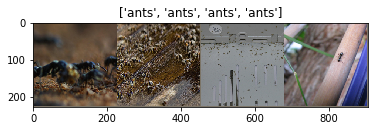

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/yuany/.torch/models/resnet18-5c106cde.pth
100.0%


In [8]:
print(num_ftrs)

512


In [9]:
print(model_ft)

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

In [12]:
modules = list(model_ft.children())[:-1]
resnet18_feature = nn.Sequential(*modules)

In [13]:
inputs, classes = next(iter(dataloaders['val']))
print(classes)


 0
 1
 1
 1
[torch.LongTensor of size 4]



In [15]:
inputs, labels = Variable(inputs), Variable(classes)
outputs = resnet18_feature(inputs)

In [17]:
outputs.size()

torch.Size([4, 512, 1, 1])

In [27]:
print(outputs[1,:2,])

Variable containing:
(0 ,.,.) = 
  1.5410

(1 ,.,.) = 
  0.9101
[torch.FloatTensor of size 2x1x1]



In [39]:
out1 = outputs.resize(4,512)
out1.size()

torch.Size([4, 512])

In [31]:
print(out1[1,:2])

Variable containing:
 1.5410
 0.9101
[torch.FloatTensor of size 2]



In [37]:
out1_array = np.array(out1)

In [44]:
out1_array.shape

(4,
 512,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1)

In [41]:
np.savetxt('resnet18_ft.txt',out1_array,fmt='%.4e')